# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

## Data preparation

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [2]:
# Importing tools and modules for data preperation
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import splitfolders

In [3]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading kaggle dataset
# Cell output cleared as only contains data download progress
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Creating parent folder directory for data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

In [5]:
# Splitting data into train, test, and validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15,0.15))

Copying files: 10560 files [00:01, 6652.37 files/s]


In [6]:
# Creating directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [7]:
# Variable to rescale data as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=7390,
                                              seed=42
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=1588,
                                             seed=42
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=1582,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [9]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [10]:
# Add some data exploration stuff

In [11]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

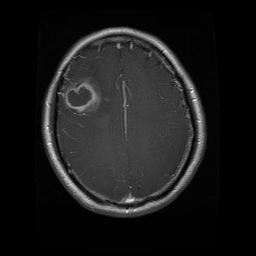

In [12]:
array_to_img(train_images[2])

# Modeling

In [13]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [14]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [15]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [16]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### Base CNN Model

In [17]:
base_cnn = Sequential()

In [18]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dropout(0.5))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [19]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=100,
                                validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.4922 - loss: 1.7197 - val_accuracy: 0.7895 - val_loss: 0.5597
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7599 - loss: 0.6016 - val_accuracy: 0.8432 - val_loss: 0.4059
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8180 - loss: 0.4587 - val_accuracy: 0.8736 - val_loss: 0.3305
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8722 - loss: 0.3359 - val_accuracy: 0.8976 - val_loss: 0.2805
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8969 - loss: 0.2651 - val_accuracy: 0.9102 - val_loss: 0.2482
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9025 - loss: 0.2408 - val_accuracy: 0.9166 - val_loss: 0.2441
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9318 - loss: 0.1729 - val_accuracy: 0.9241 - val_loss: 0.2240
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9368 - loss: 0.1647 - val_accuracy: 0.9324 -

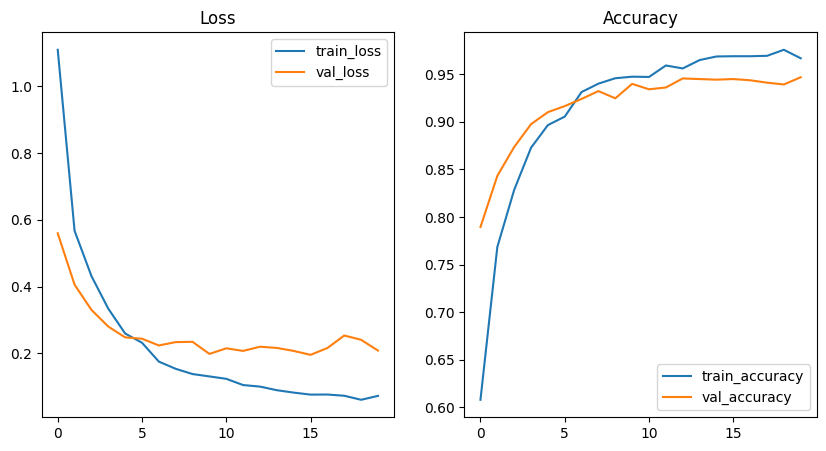

In [21]:
plot_results([base_cnn_results])

In [22]:
model_evaluation(base_cnn, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9988 - loss: 0.0083
Train Data, Loss: 0.0092, Accuracy: 0.9982
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9478 - loss: 0.2225
Val Data, Loss: 0.2087, Accuracy: 0.9469


### Base DenseNet Model

In [23]:
dn_base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [25]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [26]:
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=20,
                                          batch_size=100,
                                          validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7501 - loss: 0.6748 - val_accuracy: 0.6157 - val_loss: 2.9333
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9376 - loss: 0.1827 - val_accuracy: 0.8230 - val_loss: 0.8471
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9555 - loss: 0.1396 - val_accuracy: 0.8357 - val_loss: 0.9868
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9682 - loss: 0.1123 - val_accuracy: 0.9317 - val_loss: 0.2320
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9763 - loss: 0.0851 - val_accuracy: 0.7838 - val_loss: 0.6990
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9782 - loss: 0.0703 - val_accuracy: 0.8913 - val_loss: 0.6076
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9869 - loss: 0.0491 - val_accuracy: 0.9286 - val_loss: 0.2859
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9894 - loss: 0.0490 - val_accura

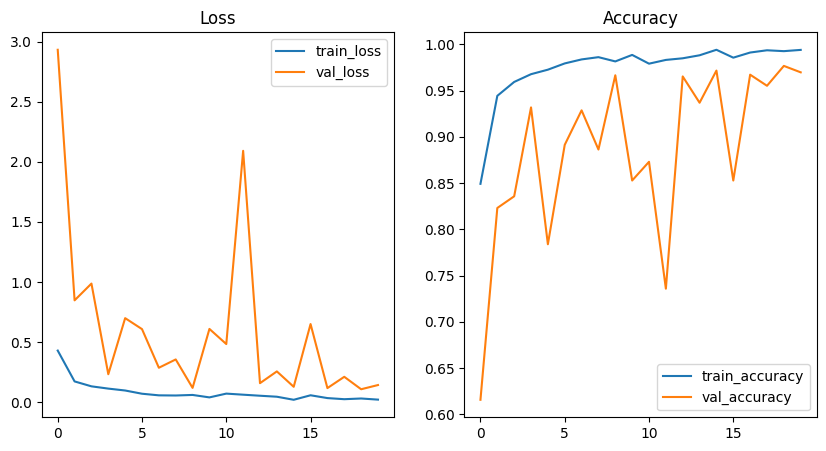

In [27]:
plot_results([base_densenet_results])

In [28]:
model_evaluation(base_densenet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.9930 - loss: 0.0207
Train Data, Loss: 0.0233, Accuracy: 0.9922
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.9690 - loss: 0.1434
Val Data, Loss: 0.1420, Accuracy: 0.9697


### Base ResNet Model

In [29]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [31]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [32]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=100,
                                      validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 126s 798ms/step - accuracy: 0.7456 - loss: 0.6921 - val_accuracy: 0.2219 - val_loss: 41.0828
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9336 - loss: 0.2134 - val_accuracy: 0.3559 - val_loss: 1.4782
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9493 - loss: 0.1675 - val_accuracy: 0.2560 - val_loss: 1.7961
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9677 - loss: 0.1250 - val_accuracy: 0.3559 - val_loss: 5.6332
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9708 - loss: 0.1011 - val_accuracy: 0.3559 - val_loss: 2.6447
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.9839 - loss: 0.0652 - val_accuracy: 0.3565 - val_loss: 1.8547
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9853 - loss: 0.0565 - val_accuracy: 0.3559 - val_loss: 3.2339
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9866 - loss: 0.0483 - val_ac

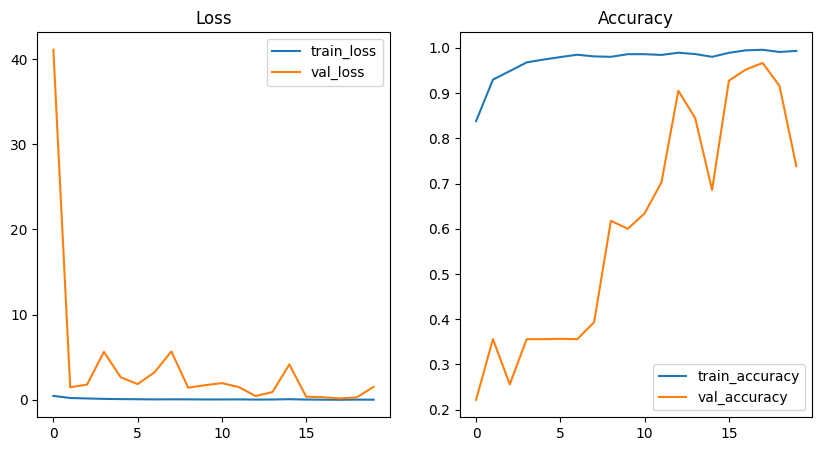

In [33]:
plot_results([base_resnet_results])

In [34]:
model_evaluation(base_resnet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7773 - loss: 1.2424
Train Data, Loss: 1.2304, Accuracy: 0.7767
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.7466 - loss: 1.4057
Val Data, Loss: 1.5359, Accuracy: 0.7383


# DenseNet Model

In [41]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5, restore_best_weights=True)

In [36]:
dn_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [50]:
dn_model = Sequential()
dn_model.add(dn_base_model)
dn_model.add(layers.GlobalAveragePooling2D())
dn_model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(l2=0.2)))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(32, activation='relu'))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(10, activation='relu'))
dn_model.add(layers.Dense(4, activation='softmax'))

dn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

dn_model_results = dn_model.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=150,
                                validation_data=(val_images, val_labels),
                                callbacks=[early_stop])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.6067 - loss: 16.9013 - val_accuracy: 0.9399 - val_loss: 2.5105
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9403 - loss: 1.5341 - val_accuracy: 0.9178 - val_loss: 0.4600
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9769 - loss: 0.2170 - val_accuracy: 0.9570 - val_loss: 0.2326
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.9849 - loss: 0.1175 - val_accuracy: 0.9772 - val_loss: 0.1133
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.9874 - loss: 0.0957 - val_accuracy: 0.9772 - val_loss: 0.1776
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9887 - loss: 0.0981 - val_accuracy: 0.9753 - val_loss: 0.1677
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9821 - loss: 0.1169 - val_accuracy: 0.9134 - val_loss: 0.5022
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.9756 - loss: 0.1292 - val_accur

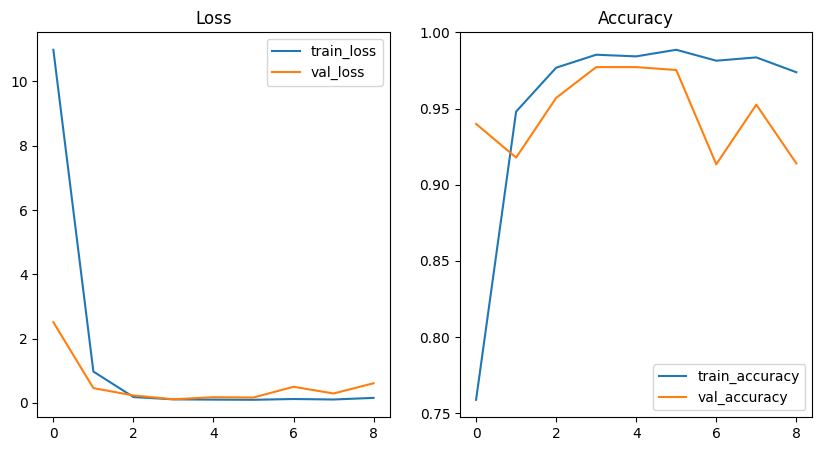

In [51]:
plot_results([dn_model_results])

In [52]:
model_evaluation(dn_model, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9960 - loss: 0.0570
Train Data, Loss: 0.0594, Accuracy: 0.9954
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9765 - loss: 0.1806
Val Data, Loss: 0.1677, Accuracy: 0.9753


In [53]:
# Getting test data pedictions
test_img_pred = base_densenet.predict(test_images)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_true_labels, test_img_pred_labels))

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       564
           1       0.98      0.97      0.97       352
           2       0.98      0.99      0.98       265
           3       0.99      0.97      0.98       407

    accuracy                           0.98      1588
   macro avg       0.98      0.98      0.98      1588
weighted avg       0.98      0.98      0.98      1588



# Evaluation

# Limitations

# Next Steps